## MOUNT Google Drive

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!lscpu |grep 'Model name'
!lscpu |grep 'Core(s) per socket:'
!free -h
!lscpu |grep 'Thread(s) per core'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Core(s) per socket:  4
              total        used        free      shared  buff/cache   available
Mem:            51G        986M         47G        1.2M        2.1G         49G
Swap:            0B          0B          0B
Thread(s) per core:  2


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec 18 16:25:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import random
import os, sys, time
from PIL import Image
import torchvision.transforms as T
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

sys.path.append('/content/drive/MyDrive/ml_epfl/ml_road_segmentation/script/')
#from helper_functions import *

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## CONSTANTS

In [13]:
CHECKPOINT_PATH ="/content/drive/MyDrive/ml_epfl/ml_road_segmentation/checkpoint/current_checkpoint.pt"
BEST_MODEL_PATH ="/content/drive/MyDrive/ml_epfl/ml_road_segmentation/checkpoint/best_model.pt"
NBR_EPOCHS = 100
BATCH_SIZE = 1
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6
GAMMA = 1
K_FOLD = 4
VALIDATION_SET_IDX = 0
BATCH_SIZE_VAL = 5
SEED = 0
DIM_IMG_TRAIN = 400

## Auxiliary functions related to the model

In [7]:
def format_time(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [8]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state:            checkpoint we want to save
    is_best:          boolean to indicates if it is the best checkpoint
    checkpoint_path:  path to save checkpoint
    best_model_path:  path to save best model
    """
    torch.save(state, checkpoint_path)
    # if it is a best model, save the model's weights
    if is_best:
        torch.save(model.state_dict(), best_model_path)

In [9]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model:           model that we want to load checkpoint parameters into       
    optimizer:       optimizer we defined in previous training
    
    Return model, optimizer, scheduler, epoch value, f1 score
    """
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # Get epoch number, f1_max, scheduler
    epoch = checkpoint['epoch']
    f1_max = checkpoint['f1_max']
    scheduler = checkpoint['scheduler']
    f1_validation = checkpoint['f1_validation']
    acc_validation = checkpoint['acc_validation']
    f1_training = checkpoint['scheduler']
    acc_training = checkpoint['acc_training']


    return model, optimizer, scheduler, epoch, f1_max, f1_validation, acc_validation, f1_training, acc_training

In [10]:
# FUNCTIONS FOR DATASET AUGMENTATION

#Constants
DIM_IMG = 400
DIM_IMG_CROP=DIM_IMG//2
NB_ROT = 10
ANGLE_ROTATION = 9
    
#Rotation
def rotation(imgs):
    rot_imgs = [T.functional.rotate(imgs[i], ANGLE_ROTATION*(i+1), expand=False)
                for _ in range(NB_ROT)
                for i in range(len(imgs))
               ]
    return rot_imgs

def compose_all_functions_for_data(imgs):
    r = imgs + rotation(imgs)
    return r

def load_train_dataset():
    #root_dir = "../data/training/"
    root_dir = "/content/drive/MyDrive/ml_epfl/ml_road_segmentation/data/training/"
    image_dir = root_dir + "images/"
    gt_dir = root_dir + "groundtruth/"
    files = os.listdir(image_dir)
    n = len(files)

    to_tensor = T.ToTensor()
    imgs = [to_tensor(Image.open(image_dir + files[i])) for i in range(n)]
    gt_imgs = [to_tensor(Image.open(gt_dir + files[i])) for i in range(n)]
    return (imgs, gt_imgs)

## UNET model

In [11]:
def double_conv(nbr_channels_in, nbr_channels_out):
    return nn.Sequential(
      nn.Conv2d(nbr_channels_in, nbr_channels_out, (3,3), padding=(1, 1)),
      nn.BatchNorm2d(nbr_channels_out),
      nn.ReLU(),
      nn.Conv2d(nbr_channels_out, nbr_channels_out, (3,3), padding=(1, 1)),
      nn.ReLU(),
      nn.BatchNorm2d(nbr_channels_out),
)


def one_step_up(x, x_d_i, pre_up_i, up_i):
    return up_i(torch.cat((pre_up_i(x), x_d_i), dim=1))


class u_net(nn.Module):
    def __init__(self):
        super(u_net, self).__init__()

        self.down_pooling = nn.MaxPool2d(2, 2)

        # Convolution Downwards
        self.down_1 = double_conv(3, 64) 
        self.down_2 = double_conv(64, 128)
        self.down_3 = double_conv(128, 256)
        self.down_4 = double_conv(256, 512)
        self.middle =  double_conv(512, 1024)
        
        # Upconvolution
        self.pre_up_1 = nn.ConvTranspose2d(1024, 512, (2, 2), (2, 2))
        self.up_1 = double_conv(512 + 512, 512)
                
        self.pre_up_2 = nn.ConvTranspose2d(512, 256, (2, 2), (2, 2))
        self.up_2 = double_conv(256 + 256, 256)
          
        self.pre_up_3 = nn.ConvTranspose2d(256, 128, (2, 2), (2, 2))
        self.up_3 = double_conv(128 + 128, 128)

        self.pre_up_4 = nn.ConvTranspose2d(128, 64, (2, 2), (2, 2))
        self.up_4 = double_conv(64 + 64, 64)

        self.final_convolution = nn.Conv2d(64, 2, (1,1))
        

    def forward(self, x):
        x_d_1 = self.down_1(x)
        x_d_2 = self.down_2(self.down_pooling(x_d_1))
        x_d_3 = self.down_3(self.down_pooling(x_d_2))
        x_d_4 = self.down_4(self.down_pooling(x_d_3))

        x = self.middle(self.down_pooling(x_d_4))

        x = one_step_up(x, x_d_4, self.pre_up_1, self.up_1)
        x = one_step_up(x, x_d_3, self.pre_up_2, self.up_2)
        x = one_step_up(x, x_d_2, self.pre_up_3, self.up_3)
        x = one_step_up(x, x_d_1, self.pre_up_4, self.up_4)
        
        return self.final_convolution(x)


## Dataset loading

In [12]:
class imagesDataset(Dataset): 
    def __init__(self, K_fold, validation_set_idx, batch_size_val, seed):
        X, Y = load_train_dataset()

        #tresholding ground_truth values
        Y = [(y > 0.5).long() for y in Y]
        shape_y = Y[0].shape
        
        #shuffling
        random.seed(seed)
        idx_list = list(range(len(X)))
        random.shuffle(idx_list)
        random.seed()
        X = [X[idx] for idx in idx_list]
        Y = [Y[idx] for idx in idx_list]
        
        #K_fold separation
        fold_size = len(X) // K_fold
        start_validation_idx = validation_set_idx * fold_size
        end_validation_idx = start_validation_idx + fold_size
        self.X_train = X[slice(0, start_validation_idx)] + X[slice(end_validation_idx, None)]
        self.Y_train = Y[slice(0, start_validation_idx)] + Y[slice(end_validation_idx, None)]
        self.X_validation = X[slice(start_validation_idx, end_validation_idx)]
        self.Y_validation = Y[slice(start_validation_idx, end_validation_idx)]

        #data augmentation
        self.X_train = compose_all_functions_for_data(self.X_train)
        self.Y_train = compose_all_functions_for_data(self.Y_train)
        self.X_validation = compose_all_functions_for_data(self.X_validation)
        self.Y_validation = compose_all_functions_for_data(self.Y_validation)
        self.n_samples = len(self.X_train)
        
        #casting into tensors
        self.X_train = torch.stack(self.X_train)
        self.X_validation = torch.stack(self.X_validation)
        self.Y_train = torch.reshape(torch.stack(self.Y_train) , (-1, shape_y[1], shape_y[2]))
        self.Y_validation = torch.reshape(torch.stack(self.Y_validation) , (-1, shape_y[1], shape_y[2]))

        #creating dataloader for validation data
        class dataset_validation(Dataset):
            def __init__(s,x,y):
                s.x = x
                s.y = y
                s.size = len(s.x)
            def __getitem__(s, index):
                return s.x[index], s.y[index]
            def __len__(s):
                return s.size
               
        self.validation_data_loader = torch.utils.data.DataLoader(
            dataset_validation(self.X_validation, self.Y_validation),
            batch_size = batch_size_val, shuffle = False)
        
        
    def __getitem__(self, index):
        return self.X_train[index], self.Y_train[index]

    def __len__(self):
        return self.n_samples
    
    def get_validation_dataloader(self):
        return self.validation_data_loader


dataset = imagesDataset(K_FOLD, VALIDATION_SET_IDX, BATCH_SIZE_VAL, SEED)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)
validation_dataloader = dataset.get_validation_dataloader()
print(len(dataset))

825


## TRAINING

In [14]:
def compute_scores(loader):
    #computing F1 score on validation data
    tp, fp, fn, tn = 0, 0, 0, 0
    for (data, target) in loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
        prediction = torch.argmax(output, dim = 1)
        confusions = prediction / target
        tp += torch.sum(confusions == 1).item()
        fp += torch.sum(confusions == float('inf')).item()
        fn += torch.sum(confusions == 0).item()
        tn += torch.sum(confusions == float("nan")).item()
    f1_score = 2 * tp / (2 * tp + fp + fn)
    accuracy = (tp + tn) / (tp + tn + fp+ fn)
    return f1_score, accuracy

In [15]:
def train(n_epochs, data_loader, model, optimizer, scheduler, criterion, device, checkpoint_path, best_model_path, f1_init):
    train_loader = data_loader
    validation_loader = train_loader.dataset.get_validation_dataloader()
    f1_max = f1_init
    
    save_f1_validation = []
    save_acc_validation = []
    save_f1_training = []
    save_acc_training = []

    for epoch in range(n_epochs):
        start_time_epoch = time.time()
        loss_list = []
        
        # Train the model for one epoch
        model.train()
        for (data, target) in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
        loss_epoch = np.mean(loss_list)

        model.eval()
        #computing scores on validation data
        f1_score_val, accuracy_score_val = compute_scores(validation_loader)
        save_f1_validation.append(f1_score_val)
        save_acc_validation.append(accuracy_score_val)

        #computing scores on training data
        f1_score_train, accuracy_score_train = compute_scores(train_loader)
        save_f1_training.append(f1_score_train)
        save_acc_training.append(accuracy_score_train)

        end_time_epoch = time.time()

        # Prepare saving of the model
        checkpoint = {
            'epoch': epoch,
            'f1_max': f1_max,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler,
            'f1_validation' : save_f1_validation,
            'acc_validation' : save_acc_validation,
            'f1_training' : save_f1_training,
            'acc_training' : save_acc_training,
        }

        if f1_score_val > f1_max:
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            f1_max = f1_score_val
        
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        #print(f"Epoch {epoch} || Loss:{loss_epoch:.6f} || Training F1 {f1_score_train:.6f} || Training Accuracy {accuracy_score_train:.6f} || Validation F1 {f1_score_val:.6f} || Validation Accuracy {accuracy_score_val:.6f} || Max F1 {f1_max:.6f} || LR {scheduler.get_last_lr()[0]:.6f} || Duration {format_time(end_time_epoch-start_time_epoch)}"+"\n")  
        scheduler.step()

In [16]:
LOAD_BEST_MODEL = False
LOAD_LAST_CHECKPOINT = not LOAD_BEST_MODEL
COLD_START = False

# Declare UNET model, otimizer, adaptative learning rate and loss function
model =  u_net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ExponentialLR(optimizer, GAMMA)
criterion = nn.CrossEntropyLoss()
f1_max = 0

if not COLD_START:
    if LOAD_LAST_CHECKPOINT and not LOAD_BEST_MODEL:
        model, optimizer, scheduler, epoch, f1_max, _ , _, _, _  = load_ckp(CHECKPOINT_PATH, model, optimizer)
    
    if not LOAD_LAST_CHECKPOINT and LOAD_BEST_MODEL:
        model.load_state_dict(torch.load(BEST_MODEL_PATH))

In [17]:
#train(NBR_EPOCHS, train_loader, model, optimizer, scheduler, criterion, device, CHECKPOINT_PATH, BEST_MODEL_PATH, f1_max)

## K-FOLD CROSS VALIDATION

In [ ]:
CHECKPOINT_K_FOLD_PATH_ROOT ="/content/drive/MyDrive/ml_epfl/ml_road_segmentation/checkpoint/k_folds_checkpoints/"
BEST_MODEL_K_FOLD_PATH_ROOT ="/content/drive/MyDrive/ml_epfl/ml_road_segmentation/checkpoint/k_folds_checkpoints/"

# Constants K-Fold
K_FOLD = 4
LEARNING_RATE_K_FOLD = 1e-3
WEIGHT_DECAY_K_FOLD = 1e-6
MOMENTUM_F_FOLD = 0.99
GAMMA_K_FOLD = 1
SEED_K_FOLD = 0
NBR_EPOCHS_K_FOLD = 30

opti_sgd = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE_K_FOLD, momentum=MOMENTUM_F_FOLD)
opti_adam = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE_K_FOLD, weight_decay=WEIGHT_DECAY_K_FOLD)
opti_adam_w = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE_K_FOLD, weight_decay=WEIGHT_DECAY_K_FOLD)

OPTIMIZERS = [(opti_sgd, "SGD_"), (opti_adam, "ADAM_"), (opti_adam_w, "ADAM_W_")]

for optimizer, opti_name in OPTIMIZERS:
    for idx_validaton_set in range(K_FOLD):
        print(f'Optimizer {opti_name[:-1]} - fold {idx_validaton_set}')
        model =  u_net().to(device)
        scheduler = ExponentialLR(optimizer, GAMMA_K_FOLD)
        criterion = nn.CrossEntropyLoss()
        f1_max = 0

        dataset = imagesDataset(K_FOLD, idx_validaton_set, BATCH_SIZE_VAL, SEED_K_FOLD)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)
        validation_dataloader = dataset.get_validation_dataloader()

        # Give correct paths
        CHECKPOINT_K_FOLD_PATH = CHECKPOINT_K_FOLD_PATH_ROOT + opti_name + 'fold_' + str(idx_validaton_set) +'_all_data.pt'
        BEST_MODEL_K_FOLD_PATH = BEST_MODEL_K_FOLD_PATH_ROOT + opti_name + 'fold_' + str(idx_validaton_set) +'_model.pt'
        train(NBR_EPOCHS_K_FOLD, train_loader, model, optimizer, scheduler, criterion, device, CHECKPOINT_K_FOLD_PATH, BEST_MODEL_K_FOLD_PATH, f1_max)

Optimizer SGD - fold 0


## TESTING

In [ ]:
# Utilities
to_tensor = T.ToTensor() 
toPIL = T.ToPILImage()

In [ ]:
def load_test_dataset():
    root_test_dir = "/content/drive/MyDrive/ml_epfl/ml_road_segmentation/data/test_set_images/"
    test_files = os.listdir(root_test_dir)
    n = len(test_files)
    test_imgs = [to_tensor(Image.open(root_test_dir + test_files[i] +'/'+ test_files[i]+'.png').resize((DIM_IMG_TRAIN,DIM_IMG_TRAIN))).reshape((1, 3, 400, 400)) for i in range(n)]
    return test_imgs
  
test_images = load_test_dataset()

In [ ]:
def make_predictions(model, test_images):
    model.eval()
    predicted_images = [torch.argmax(model(img.to(device)), dim = 1).cpu().float() for img in test_images]
    return predicted_images

predictions = make_predictions(model, test_images)

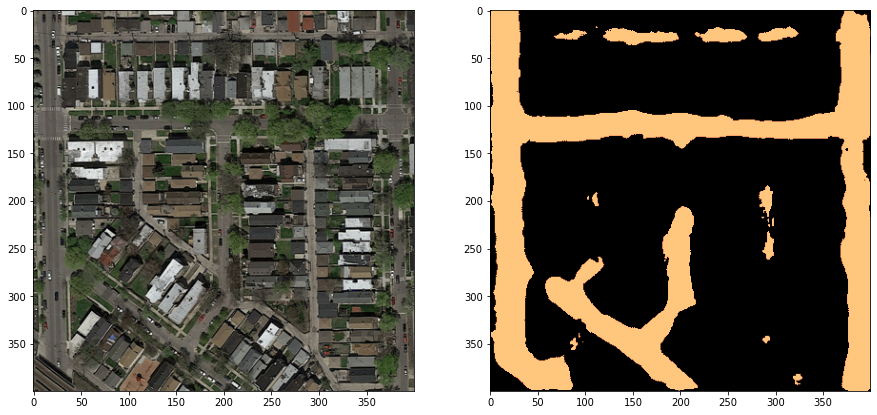

In [ ]:
plt.figure(figsize=(15,15))
IMG_INDEX = 1
images = [toPIL(test_images[IMG_INDEX].reshape((3, 400, 400))), toPIL(predictions[IMG_INDEX])]
for i, image in enumerate(images):
    plt.subplot(1, 2, i+1)
    plt.imshow(image)

In [ ]:
def train_on_single_sample(n_epochs, im_test, gt_test, model, optimizer, scheduler, criterion, device, checkpoint_path, best_model_path):
    for epoch in range(n_epochs):
        data, target = im_test.to(device), gt_test.to(device)

        model.train()
        # Evaluate the network (forward pass)
        output = model(data)
        loss = criterion(output, target)

        # Compute the gradient
        optimizer.zero_grad()
        loss.backward()

        # Update the parameters of the model with a gradient step
        optimizer.step()

        #computing prediction to judge the model
        prediction = torch.argmax(output, dim = 1)

        #computing F1 score
        model.eval()
        tp, fp, fn = 0, 0, 0
        confusions = prediction / target
        tp += torch.sum(confusions == 1).item()
        fp += torch.sum(confusions == float('inf')).item()
        fn += torch.sum(confusions == 0).item()
        f1_score = 2 * tp / (2 * tp + fp + fn)
        
        #computing accuracy
        correct_predictions = prediction.eq(target)
        accuracy = correct_predictions.sum().float() / correct_predictions.nelement()
  

        print(f"Epoch {epoch} || Loss:{loss:.6f} || Training F1 {f1_score:.6f} || Training Accuracy : {accuracy}|| Learning rate {scheduler.get_last_lr()[0]:.6f}"+"\n")  
        #scheduler.step()
        
    return 

In [ ]:
model = u_net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ExponentialLR(optimizer, GAMMA)
criterion = nn.CrossEntropyLoss()

In [ ]:
im_test, gt_test = next(iter(train_loader))
toPIL = T.ToPILImage()

In [ ]:
toPIL(im_test.reshape(3, 400, 400))

In [ ]:
toPIL(gt_test.float())

In [ ]:
train_on_single_sample(NBR_EPOCHS, im_test, gt_test, model, optimizer, scheduler, criterion, device, CHECKPOINT_PATH, BEST_MODEL_PATH)

In [ ]:
model.eval()
print(im_test.shape)
output = model(im_test.to(device))
prediction = torch.argmax(output, dim = 1).cpu()
toPIL(prediction.float())